# Grand Canonical Lattice Gas Simulation
This notebook implements a grand canonical Monte Carlo simulation of the lattice gas model with chemical potential set to the coexistence value (μ=0) for any temperature T.

## Features
1. **Grand canonical moves**: particle insertion and deletion.
2. **Chemical potential μ** set to coexistence (μ=0) due to particle-hole symmetry.
3. **Monitoring**: tracks particle number and acceptance ratios.
4. **Analysis**: final configuration, density time series, structure factor, and g(r).

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import time

In [2]:
class GrandCanonicalLatticeGas:
    def __init__(self, L, T, mu=0.0):
        self.L = L
        self.T = T
        self.mu = mu
        # start from half occupancy for symmetry
        self.lattice = np.random.rand(L, L) < 0.5
        self.accept_insert = 0
        self.attempt_insert = 0
        self.accept_delete = 0
        self.attempt_delete = 0

    def _delta_energy_interaction(self, i, j):
        # energy change due to interaction when flipping occupancy at (i,j)
        L = self.L
        # current occupancy
        occ = self.lattice[i, j]
        # sum of neighbor occupancies
        neigh = sum(self.lattice[(i+di)%L, (j+dj)%L] for di, dj in [(-1,0),(1,0),(0,-1),(0,1)])
        # if inserting, occ goes 0->1: ΔE_int = -neigh; if deleting, 1->0: ΔE_int = +neigh
        return -neigh if not occ else +neigh

    def step(self):
        # choose random site
        i, j = random.randrange(self.L), random.randrange(self.L)
        occ = self.lattice[i, j]
        # decide insertion or deletion
        if occ:
            # attempt deletion
            self.attempt_delete += 1
            dE_int = self._delta_energy_interaction(i, j)
            dE = dE_int + self.mu  # delete: remove mu*N term
            if dE <= 0 or random.random() < np.exp(-dE / self.T):
                self.lattice[i, j] = False
                self.accept_delete += 1
        else:
            # attempt insertion
            self.attempt_insert += 1
            dE_int = self._delta_energy_interaction(i, j)
            dE = dE_int - self.mu  # insert: add mu*N term
            if dE <= 0 or random.random() < np.exp(-dE / self.T):
                self.lattice[i, j] = True
                self.accept_insert += 1

    def run(self, n_steps):
        start = time.time()
        densities = []
        for step in range(n_steps):
            self.step()
            if step % 1000 == 0:
                densities.append(self.lattice.mean())
        duration = time.time() - start
        acc_ins = self.accept_insert / self.attempt_insert if self.attempt_insert else 0
        acc_del = self.accept_delete / self.attempt_delete if self.attempt_delete else 0
        print(f"Run time: {duration:.2f}s")
        print(f"Insertion acc: {acc_ins:.3f}, Deletion acc: {acc_del:.3f}")
        return np.array(densities)

In [3]:
def compute_structure_factor(config):
    rho = config.astype(float) - config.mean()
    S = np.abs(fftshift(fft2(rho)))**2
    return S

In [4]:
def compute_pair_correlation(config):
    L = config.shape[0]
    particles = np.argwhere(config)
    distances = np.sqrt(((particles[:, None, :] - particles[None, :, :])**2).sum(axis=2))
    bins = np.arange(0.5, L/2 + 1)
    hist, edges = np.histogram(distances.flatten(), bins=bins)
    r = 0.5 * (edges[:-1] + edges[1:])
    rho = config.mean()
    norm = 2 * np.pi * r * (bins[1] - bins[0]) * rho * len(particles)
    return r, hist / norm

Run time: 1.53s
Insertion acc: 1.000, Deletion acc: 0.305


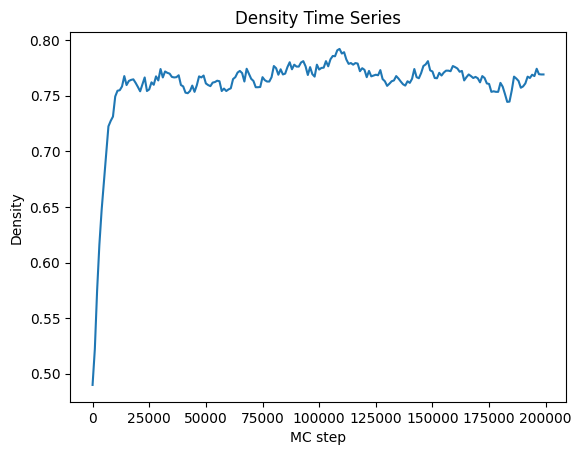

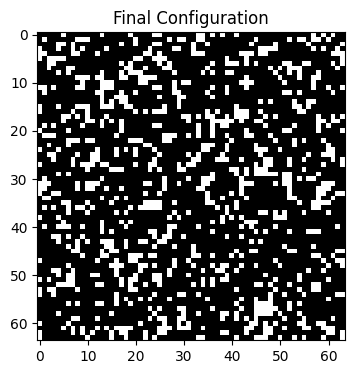

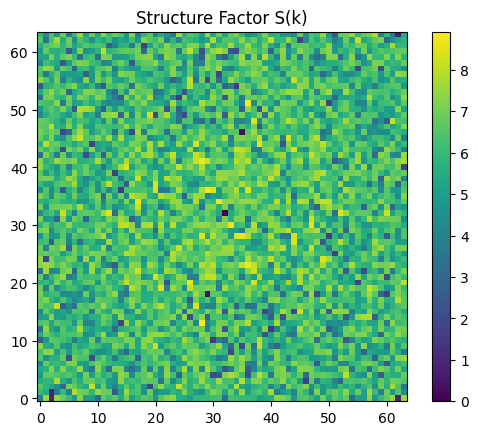

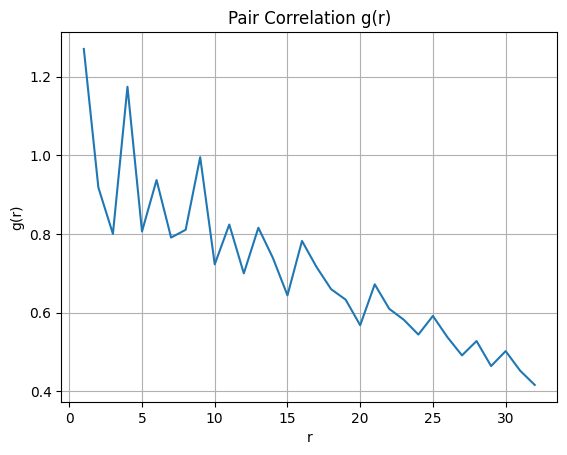

In [8]:
# Demonstration at T<Tc
L, T = 64, 2.5  # below critical T~2.269
mu_coex = 0.0  # due to symmetry
steps = 200000
gc = GrandCanonicalLatticeGas(L, T, mu_coex)
densities = gc.run(steps)

plt.figure()
plt.plot(np.arange(0, steps, 1000), densities)
plt.xlabel('MC step')
plt.ylabel('Density')
plt.title('Density Time Series')
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(gc.lattice, cmap='Greys')
plt.title('Final Configuration')
plt.show()

S = compute_structure_factor(gc.lattice)
plt.figure()
plt.imshow(np.log1p(S), origin='lower')
plt.title('Structure Factor S(k)')
plt.colorbar()
plt.show()

r, g = compute_pair_correlation(gc.lattice)
plt.figure()
plt.plot(r, g)
plt.title('Pair Correlation g(r)')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.grid(True)
plt.show()